This is the 2D equivalent of the 1D example. It is meant to show that ROMC method scales well to bigger dimensions.

In [22]:
import timeit

import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
import scipy.ndimage as ndimage
import scipy.stats as ss
from mpl_toolkits import mplot3d

import elfi

np.random.seed(21)

In [23]:
class Prior:
    def rvs(self, size=None, random_state=None):
        # size from (BS,) -> (BS,1)
        if size is not None:
            size = np.concatenate((size, [1]))
        return ss.uniform(loc=-2.5, scale=5).rvs(size=size, random_state=random_state)

    def pdf(self, theta):
        return ss.uniform(loc=-2.5, scale=5).pdf(theta)

    def logpdf(self, theta):
        return ss.uniform(loc=-2.5, scale=5).logpdf(theta)

In [24]:
class Likelihood:
    def rvs(self, th1, th2, seed=None):
        assert isinstance(th1, np.ndarray)
        assert isinstance(th2, np.ndarray)
        assert th1.ndim == 2
        assert th2.ndim == 2
        assert np.allclose(th1.shape, th2.shape)

        x = []
        for i in range(th1.shape[0]):
            cur_th = np.concatenate((th1[i], th2[i]))
            x.append(ss.multivariate_normal(mean=cur_th, cov=1).rvs(random_state=seed))
        return np.array(x)

    def pdf(self, x, th1, th2):
        assert isinstance(th1, float)
        assert isinstance(th2, float)
        assert isinstance(x, np.ndarray)

        th = np.stack((th1, th2))
        rv = ss.multivariate_normal(mean=th, cov=1)
        nof_points = x.shape[0]
        prod = 1
        for i in range(nof_points):
            prod *= rv.pdf(x[i])
        return prod

## Ground-Truth computation

In [25]:
def create_factor(x):
    lik = Likelihood()
    pr = Prior()

    def tmp_func(th1, th2):
        return lik.pdf(x, th1, th2) * pr.pdf(th1) * pr.pdf(th2)
    return tmp_func


def approximate_Z(func):
    return integrate.dblquad(func, -2.5, 2.5, lambda x: -2.5, lambda x: 2.5)[0]


def create_gt_posterior(factor, Z):
    def tmp_func(th1, th2):
        return factor(th1, th2) / Z
    return tmp_func

def plot_gt_posterior(posterior, nof_points):
    plt.figure()
    x = np.linspace(-4, 4, nof_points)
    y = np.linspace(-4, 4, nof_points)

    x, y = np.meshgrid(x, y)

    tmp = []
    for i in range(x.shape[0]):
        tmp.append([])
        for j in range(x.shape[1]):
            tmp[i].append(posterior(x[i, j], y[i, j]))
    z = np.array(tmp)
    plt.contourf(x, y, z, 40)
    plt.title('Ground-Truth Posterior PDF')
    plt.colorbar()
    plt.xlabel("th_1")
    plt.ylabel("th_2")
    plt.show(block=False)

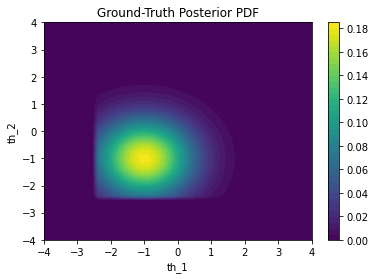

In [26]:
data = - np.array([[1.,1.]])
dim = data.shape[-1]
factor = create_factor(data)
Z = approximate_Z(factor)
gt_posterior = create_gt_posterior(factor, Z)

plot_gt_posterior(gt_posterior, nof_points=50)

## ELFI PART

In [27]:
def simulate_data(th1, th2, batch_size=10000, random_state=None):
    likelihood = Likelihood()
    return likelihood.rvs(th1, th2, seed=random_state)


def summarize(x):
    if x.ndim == 1:
        x = np.expand_dims(x, -1)
    return np.prod(x, axis=-1)

In [28]:
elfi.new_model("2D_example")
elfi_th1 = elfi.Prior(Prior(), name="th1")
elfi_th2 = elfi.Prior(Prior(), name="th2")
elfi_simulator = elfi.Simulator(simulate_data, elfi_th1, elfi_th2, observed=data, name="simulator")
dist = elfi.Distance('euclidean', elfi_simulator, name="dist")
summary = elfi.Summary(summarize, dist, name="summary")

In [29]:
left_lim = np.ones(dim)*-2.5
right_lim = np.ones(dim)*2.5
romc = elfi.ROMC(summary, left_lim=left_lim, right_lim=right_lim)

In [30]:
n1 = 100
seed = 21
romc.solve_problems(n1=n1, seed=seed)

### Solving problems ###
Time: 1.026 sec█████████████████████████████████████████████-| 99.0% Complete


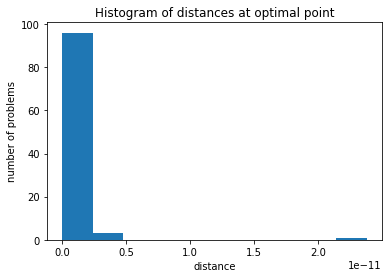

In [31]:
romc.theta_hist()

In [32]:
eps = .7
region_mode = "romc_jacobian"
assert region_mode in ["gt_full_coverage", "romc_jacobian"]

romc.estimate_regions(eps=eps, region_mode=region_mode)

### Estimating regions ###

Time: 7.507 sec ████████████████████████████████████████████-| 99.0% Complete



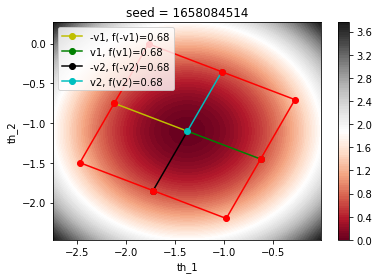

In [33]:
romc.visualize_region(2)

In [34]:
romc.eval_unnorm_posterior(theta=np.array([[1.5, 1.5]]))

array([0.])

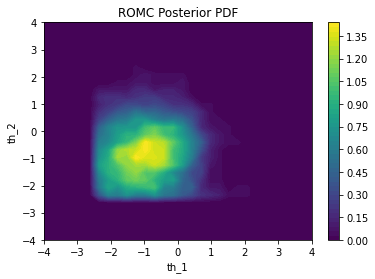

In [35]:
def plot_romc_posterior(posterior, nof_points):
    plt.figure()
    th1 = np.linspace(-4, 4, nof_points)
    th2 = np.linspace(-4, 4, nof_points)
    X, Y = np.meshgrid(th1, th2)

    x_flat = X.flatten()
    y_flat = Y.flatten()
    th = np.stack((x_flat, y_flat), -1)
    z_flat = posterior(th)
    Z = z_flat.reshape(nof_points, nof_points)
    
    plt.contourf(X, Y, Z, 50, cmap='viridis')
    plt.title('ROMC Posterior PDF')
    plt.xlabel("th_1")
    plt.ylabel("th_2")
    plt.colorbar()
    plt.show(block=False)
    
plot_romc_posterior(romc.eval_unnorm_posterior, nof_points=30)

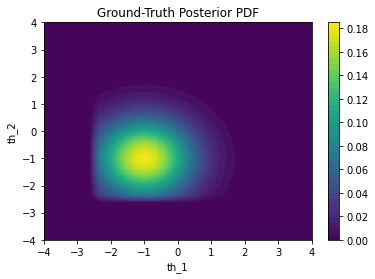

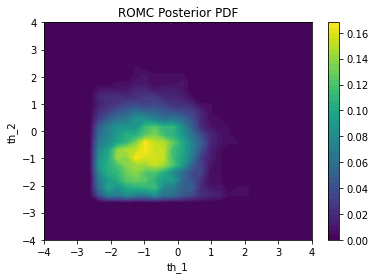

In [36]:
plot_gt_posterior(gt_posterior, nof_points=30)
plot_romc_posterior(romc.eval_posterior, nof_points=30)

In [37]:
n2 = 30
tmp = romc.sample(n2=n2)

### Getting Samples from the posterior ###

Time: 11.427 sec ███████████████████████████████████████████-| 100.0% Complete



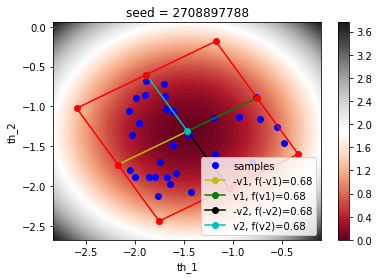

In [38]:
# As before but now it plots the samples as well
romc.visualize_region(9)

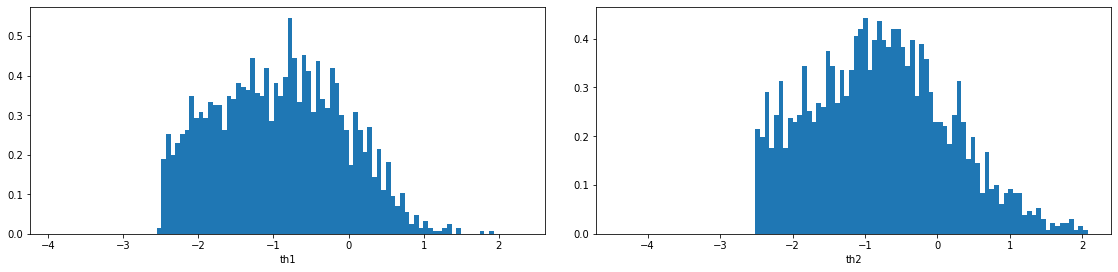

In [39]:
romc.result.plot_marginals(weights=romc.result.weights, bins=100, density=True)
plt.show()

In [40]:
romc.result.summary()

Method: ROMC
Number of samples: 3000
Sample means: th1: -0.93, th2: -0.795


In [46]:
def wrapper(x):
    res = []
    for i in range(x.shape[0]):
        res.append(gt_posterior(x[i][0], x[i][1]))
    return np.array(res)

print(elfi.methods.utils.compute_divergence(romc.eval_posterior, wrapper, limits = [(-2.5, 2.5), (-2.5, 2.5)], step=0.1, distance="Jensen-Shannon"))
# print(elfi.methods.utils.compute_divergence(wrapper, romc.eval_posterior, limits = [(-2.5, 2.5), (-2.5, 2.5)], step=0.1, distance="Jensen-Shannon"))

0.10690319901693893
0.10690319901693893


In [47]:
gt_posterior(0., 0.)

0.06726659486978342